In [17]:
# %pip install lightning torchmetrics ninja pybind11

import os, requests, zipfile, glob
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import lightning as L
import wandb
import torchmetrics

from torch.nn import    Linear, \
                        BatchNorm1d, \
                        Module
from torch.utils.data import DataLoader
from torch.utils.cpp_extension import load
from lightning.pytorch.loggers import WandbLogger
from lightning.pytorch.callbacks import ModelCheckpoint

wandb.login()  # Log in to your W&B account
L.seed_everything(42)

device = torch.device(torch.cuda.current_device()) if torch.cuda.is_available() else torch.device('cpu')
print('Available device:', device)

Seed set to 42


Available device: cpu


For this course, we will use the neuromorphic dataset [N-MNIST](https://www.garrickorchard.com/datasets/n-mnist). The dataset was captured by mounting a Dynamic Vision Sensor (event camera) on a motorized pan-tilt unit and moving the sensor while it viewed classic MNIST examples on an LCD monitor.

An event camera is a bio-inspired sensor that operates differently from a traditional camera: instead of capturing full images at a fixed frame rate, it records only pixel-level brightness changes (“events”). This asynchronous, per-pixel reporting offers several advantages, including extremely high speed, high dynamic range, and low motion blur. When the brightness change at a pixel exceeds a threshold, that pixel resets its reference level and generates an event—a discrete packet containing the pixel address, timestamp, and the polarity (sign) of the brightness change.

<img src="https://raw.githubusercontent.com/vision-agh/DNN-Course-media/refs/heads/main/lab9_gcn/figures/dvs.png" width="600px">

Let’s first download and unzip the dataset.


In [18]:
base_url = "https://data.mendeley.com/public-files/datasets/468j46mzdv/files/"
files = [
    ("39c25547-014b-4137-a934-9d29fa53c7a0/file_downloaded", "train.zip", "Train"),
    ("05a4d654-7e03-4c15-bdfa-9bb2bcbea494/file_downloaded", "test.zip",  "Test")
]

for path, zip_name, folder in files:
    if os.path.exists(zip_name) or os.path.exists(folder):
        print(f"Skipping {zip_name} (already exists)")
        continue
    url = base_url + path
    print(f"Downloading and extracting {zip_name} ...")
    with requests.get(url, stream=True) as r:
        r.raise_for_status()
        with open(zip_name, "wb") as f:
            f.write(r.content)
    with zipfile.ZipFile(zip_name, "r") as z:
        z.extractall(".")
print("Done")

Skipping train.zip (already exists)
Skipping test.zip (already exists)
Done


To read data from the binary file, we need to use a custom function. This function reads the raw byte stream and decodes it according to the dataset specification. Additionally, we ensure that the spatial coordinates (**x** and **y**) remain within the valid range of [0, 31].


In [19]:
def read_dataset(filename):
    with open(filename, 'rb') as f:
        raw_data = np.fromfile(f, dtype=np.uint8)

    raw_data = np.uint32(raw_data)
    all_y = raw_data[1::5]
    all_x = raw_data[0::5]
    all_p = (raw_data[2::5] & 128) >> 7
    all_p = all_p
    all_ts = ((raw_data[2::5] & 127) << 16) | (raw_data[3::5] << 8) | raw_data[4::5]

    time_increment = 2 ** 13
    overflow_indices = np.where(all_y == 240)[0]
    for overflow_index in overflow_indices:
        all_ts[overflow_index:] += time_increment

    td_indices = np.where(all_y != 240)[0]
    x, y, ts, p = all_x[td_indices], all_y[td_indices], all_ts[td_indices], all_p[td_indices]

    mask = (x < 32) & (y < 32)
    x, y, ts, p  = x[mask], y[mask], ts[mask], p[mask]
    p = np.int32(p)*2 - 1

    return ts, x, y, p

Read an example file from the dataset. For now, use **`00014.bin`** from the **`Train/6`** folder to ensure consistent results. Once everything works correctly, you can test other files as well.


In [20]:
ts, xs, ys, pol = read_dataset('Train/6/00014.bin')

print('Timestamps:', ts)
print('X coords:', xs)
print('Y coords:', ys)
print('Polarity:', pol)
print('Length of sample:', len(ts))

Timestamps: [  3606   4557   8290 ... 306000 307125 309032]
X coords: [15  3 18 ... 21  5 11]
Y coords: [22 31 17 ... 13  6 23]
Polarity: [-1  1  1 ... -1  1 -1]
Length of sample: 4528


We obtain lists of event spatial coordinates (**x, y**), timestamps **t**, and polarity **p**. Timestamps are in microseconds, and each sample spans roughly **300 ms**. Polarity takes values **−1** or **1**.

Because each sample (e.g. our list of **4528** events) corresponds to a single digit class, this will be a **graph-level classification** problem. Individual events carry little meaning on their own; it’s the **group** of events that forms a useful representation.

For other dataset formats, see the [PyG data cheatsheet](https://pytorch-geometric.readthedocs.io/en/latest/cheatsheet/data_cheatsheet.html). Datasets may contain a single large graph or many smaller graphs (like our N-MNIST: ~60k training samples with ~1k events per sample), may provide **predefined edges** or require you to define them (as in our case), and can vary in **feature** count (we use a single feature—polarity) and **number of classes/tasks** (10 for MNIST).

Before implementing our GCN layers and model, we’ll define a custom dataset and build graphs from events.

Starting from raw events, we need to normalize it. **300 ms** per sample is longer than necessary for our task. We can safely use just **100 ms**, reducing training data size.

We’ll take a **100 ms** slice from the middle of each sequence and **normalize time to the same range as the spatial coordinates** (0–31).


In [21]:
# we will select only 100 ms of events from middle
start_time = ts.min()
end_time = ts.max()
middle_time = (start_time + end_time) / 2
mask = (ts >= middle_time - 50000) & (ts <= middle_time + 50000)  # 100 ms = 100,000 μs, so ±50,000 μs from middle

ts = ts[mask]
xs = xs[mask]
ys = ys[mask]
pol = pol[mask]

# normalise time to range 0-31
ts_min = ts.min()
ts_max = ts.max()
ts = (ts - ts_min) / (ts_max - ts_min) * 31  # Scale to 0-31 range

events = np.column_stack((xs, ys, ts, pol))
print(events)
print(events.shape)

[[ 8.         11.          0.          1.        ]
 [ 9.         23.          0.04496736  1.        ]
 [22.         18.          0.06495286 -1.        ]
 ...
 [17.         14.         30.98188815 -1.        ]
 [15.         19.         30.99781409 -1.        ]
 [20.          8.         31.         -1.        ]]
(1251, 4)


We can visualize our events in a 3D plot using Matplotlib, allowing us to observe their spatiotemporal distribution from different perspectives.

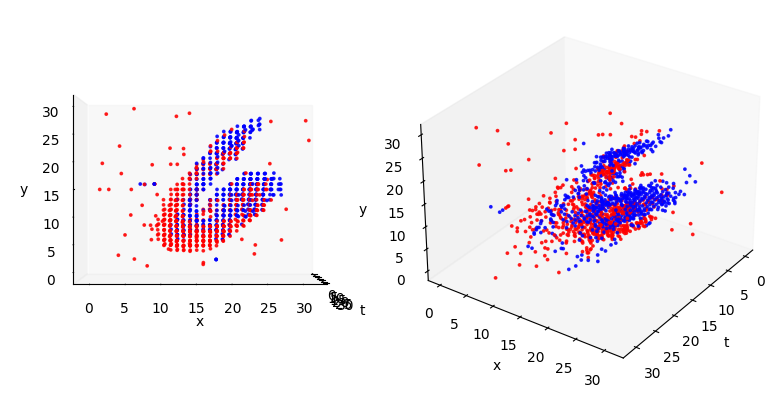

In [22]:
# Extract coordinates
x, y, t, p = events[:, 0], events[:, 1], events[:, 2], events[:, 3]

fig = plt.figure(figsize=(8, 4))

# ---- View 1: top-down ----
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
sc1 = ax1.scatter(t, x, 31 - y, c=p, cmap='bwr', s=3, alpha=0.8)
ax1.set_xlabel("t"); ax1.set_ylabel("x"); ax1.set_zlabel("y")
ax1.view_init(elev=0, azim=0)
ax1.grid(False)

# ---- View 2: angled ----
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
sc2 = ax2.scatter(t, x, 31 - y, c=p, cmap='bwr', s=3, alpha=0.8)
ax2.set_xlabel("t"); ax2.set_ylabel("x"); ax2.set_zlabel("y")
ax2.view_init(elev=30, azim=35)
ax2.grid(False)

plt.tight_layout()
plt.show()


### Generating a Graph from Events

Now it’s time to generate our **graph**.
A graph, by definition, consists of **nodes** and **edges**.
In our case, each **event** acts as a **node**, represented by its spatial and temporal coordinates (**x, y, t**) and a single **feature** — the **polarity**.

There are several ways to build a graph from events — for example, using **nearest neighbors (k-NN)** or **radius-based connections**.
In this course, we focus on the **radius graph** approach, where two nodes are connected if they lie within a certain **spatial-temporal distance** from one another.
This allows us to build **local connectivity** that reflects how events influence nearby points in both space and time.

---

### How the Radius Graph Works

Let’s denote our set of event nodes as:

$$
\mathcal{V} = { v_1, v_2, \dots, v_N }, \quad v_i = (x_i, y_i, t_i)
$$

Each node corresponds to an event’s spatial-temporal position.
To determine edges between these nodes, we compute the **pairwise Euclidean distance** between every pair of nodes in this 3D space:

$$
d_{ij}^2 = | v_i - v_j |^2 = (x_i - x_j)^2 + (y_i - y_j)^2 + (t_i - t_j)^2
$$

This expression can also be expanded algebraically as:

$$
|v_i - v_j|^2 = |v_i|^2 + |v_j|^2 - 2v_i v_j^T
$$

We then connect nodes **i** and **j** with an **edge** if this squared distance satisfies:

$$
d_{ij}^2 < r^2
$$

where ( r ) is a predefined **radius threshold** controlling the local connectivity.

This means that every event is connected to all other events that occur **close enough in space and time**.

---

### Directed, Time-Aware Edges (Causality)

To encode temporal causality, we make the graph **directed** so that **older events connect to newer events**.
Assuming events are indexed so that $(t_1\le t_2\le \dots \le t_N)$, we keep edges only in the **forward-in-time** direction:
$$
i \to j \quad \text{iff} \quad d_{ij}^2<r^2 \ \ \text{and} \ \ t_i \le t_j.
$$
In code, this is implemented by keeping only one triangular part of the adjacency **after** distance thresholding (e.g. `tril`), which enforces (i<j) and thus $(t_i\le t_j)$.
This yields a **directed, causal** radius graph that prevents backward-in-time message passing. It is important e.g. if we would like to update graph asynchronously (event-by-event), without updating event already inside graph.


---

### Optional k-Filtering

Sometimes, even within a radius, a node may have **too many neighbors**, which can lead to computational overhead or overly dense connectivity.
To handle this, we apply an additional **k-filtering step** — selecting only the **k nearest neighbors** among all nodes within the radius.

Formally, for each node ( $v_i$ ), we keep only the **k smallest distances** ( $d_{ij}$ ) such that:

$$
\text{Neighbors}(v_i) = \operatorname{argmin}_j^{(k)} d_{ij} \quad \text{subject to } d_{ij}^2 < r^2
$$

It’s a practical compromise between **radius-based locality** and **computational efficiency**, and is especially helpful when dealing with high-density data.


### Building a radius graph

1. **Squared norms of positions**
   Compute per-node power $(|v_i|^2)$ from `pos` using elementwise square (simple `**2` is enough) and a reduction over features (`.sum(dim=1, keepdim=True)`). This lets us form pairwise distances efficiently via dot products.

2. **Pairwise squared distances $([N \times N])$**
   Use the identity
   $(|v_i - v_j|^2 = |v_i|^2 + |v_j|^2 - 2v_i v_j^\top).$
   In practice: combine (`+`) the column of squared norms (`pos2`) with its transpose and subtract twice the position Gram matrix (`pos @ pos.t()`).

3. **Radius mask (exclude self-distances)**
   Create a boolean mask for neighbors within radius `r` by checking `dist2 < r**2`. Also require `dist2 > 0` to exclude self-loops and other events with same spatio-temporal position (we will add self-loops later).

4. **Temporal direction (older → newer)**
   Our events are time-sorted, so we will keep only edges from earlier to later events by taking the lower-triangular part of the mask with `torch.tril(diagonal=-1)`.
   *Note:* `diagonal=-1` ensures the diagonal remains false (no self-loops yet).

5. **Add self-loops**
   Set the diagonal entries to `True` using matching row/column indices (e.g. via `torch.arange(N)`).

6. **Optional: k-Nearest filtering (`k`)**

   * Temporarily set distances outside the current mask to `+inf` so only candidate edges remain.
   * For each node (row), pick the `k` smallest distances. Since `topk` returns largest values, apply it to the negative distances.
   * Keep only indices that are finite (valid neighbors) and update the mask accordingly.

7. **Edge list extraction**
   Convert the final boolean mask to an `edge_index` by taking coordinates of nonzero/true entries (e.g., with `nonzero(as_tuple=False)`).
   *Use case:* pass `edge_index` (and optionally the mask) to downstream GNN ops and for visualization (e.g., as an adjacency image).

---

DEBUG: edge_index shape after construction: torch.Size([2, 14079])


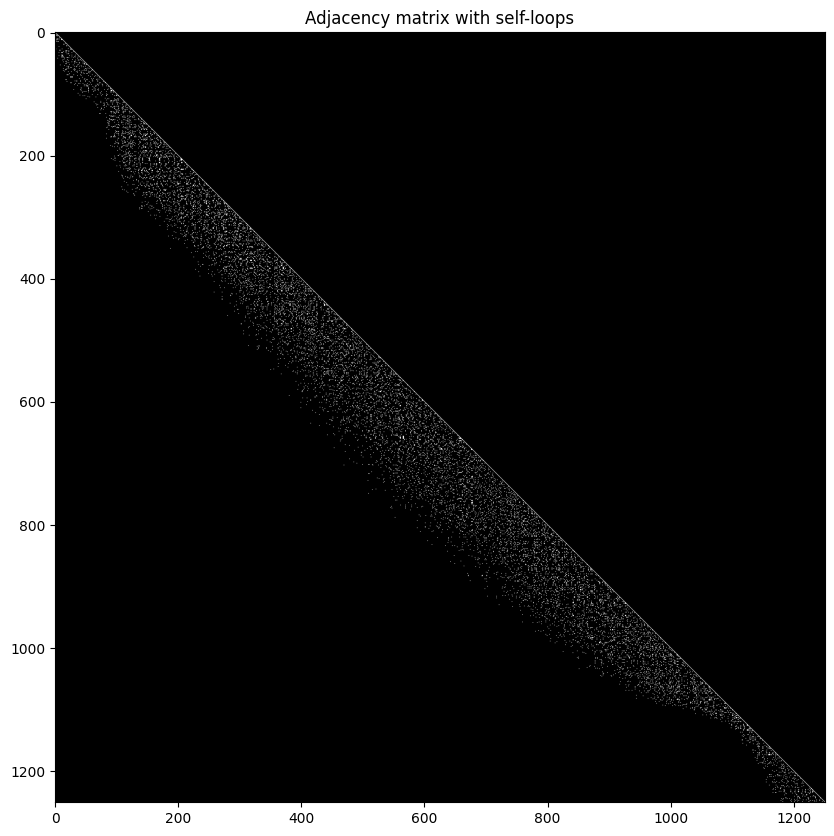

In [23]:
def radius_graph(pos: torch.Tensor, r: float, k: int = None):
    N = pos.size(0)
    
    # calculate distance node-to-node
    pos2 = (pos ** 2).sum(dim=1, keepdim=True)
    dist2 = pos2 + pos2.t() - 2 * pos @ pos.t()
    
    # check for neighbours in radius and exclude dist == 0
    mask = (dist2 < r**2) & (dist2 > 0)
    
    # we want to connect events from past to future (old_ev -> new_ev)
    mask = torch.tril(mask, diagonal=-1)
    
    # add self-loop
    mask = mask.clone()
    idx = torch.arange(N, device=pos.device)
    mask[idx, idx] = True
    
    # perform k-Nearest filtering
    if k is not None:
        dist2_masked = dist2.clone()
        dist2_masked[~mask] = float('inf')
        
        knn_vals, knn_idx = torch.topk(-dist2_masked, k, dim=1)
        
        mask_knn = torch.zeros_like(mask)
        row_idx = torch.arange(N, device=pos.device).unsqueeze(1).expand_as(knn_idx)
        valid_mask = torch.isfinite(-knn_vals)
        mask_knn[row_idx[valid_mask], knn_idx[valid_mask]] = True
        
        mask = mask & mask_knn
    
    # FIXED: Convert mask to edge_index with proper PyG format [2, num_edges]
    edge_indices = torch.nonzero(mask, as_tuple=False)
    
    # edge_indices has shape [num_edges, 2] where each row is (i, j)
    # We need to transpose it to get [2, num_edges] where:
    # - row 0: source nodes
    # - row 1: target nodes
    if edge_indices.numel() > 0:
        edge_index = edge_indices.t().contiguous()  # This gives [2, num_edges]
    else:
        # If no edges, create empty tensor with correct shape
        edge_index = torch.zeros((2, 0), dtype=torch.long, device=pos.device)
    
    print(f"DEBUG: edge_index shape after construction: {edge_index.shape}")
    return edge_index, mask
x = events[:, 3]
x = torch.tensor(x).unsqueeze(-1)

pos = events[:, :3]
pos = torch.tensor(pos)

edges, mask = radius_graph(pos, 3.0, 16)

plt.figure(figsize=(10, 10))
plt.imshow(mask.numpy(), cmap='gray')
plt.title("Adjacency matrix with self-loops")
plt.show()

We expect to see a **diagonal plus a sparse lower-triangular adjacency matrix**. This is similar to the **causal mask** used in decoder self-attention, but with a key difference: we **only keep connections within a radius (r)** rather than densely connecting each event to all previous ones. This radius-based sparsity is a core advantage for GCNs — it **reduces computational and memory complexity** by linking each event to a **non-uniform, local subset** of relevant events instead of the full sequence.

We could plug this function into our dataset; however, this implementation isn’t highly optimized. The main issue is the **(O(n^2))** cost of computing the adjacency matrix, where the number of events (n) can be in the thousands. To speed up training and validation, I prepared a function with the same behavior implemented in **C++** using simple for-loops. We can use **pybind11** to compile and bind the C++ code to Python (see `radius_cpu.cpp`). For even greater speed, a **CUDA** version could be used, but the CPU implementation is sufficient for now.

The C++ version should produce **the same number of edges** as the Python version.

In [24]:
radius_cpu_ext = load(
    name="radius_cpu",
    sources=["/home/jrosa/AGH_FILES/GSN-2025W/lab_08_gsn/radius_cpu.cpp"],
    extra_cflags=["-O3", "-fopenmp", "-std=c++17"],
    verbose=True,
)
x = x.to(torch.float32)
pos = pos.to(torch.float32)
edges = radius_cpu_ext.radius_graph_cpu(pos, 3.0, 16)

print(x.shape)
print(pos.shape)
print(edges.shape)

torch.Size([1251, 1])
torch.Size([1251, 3])
torch.Size([14079, 2])


We can also visualise our events with edges in 3D plot.

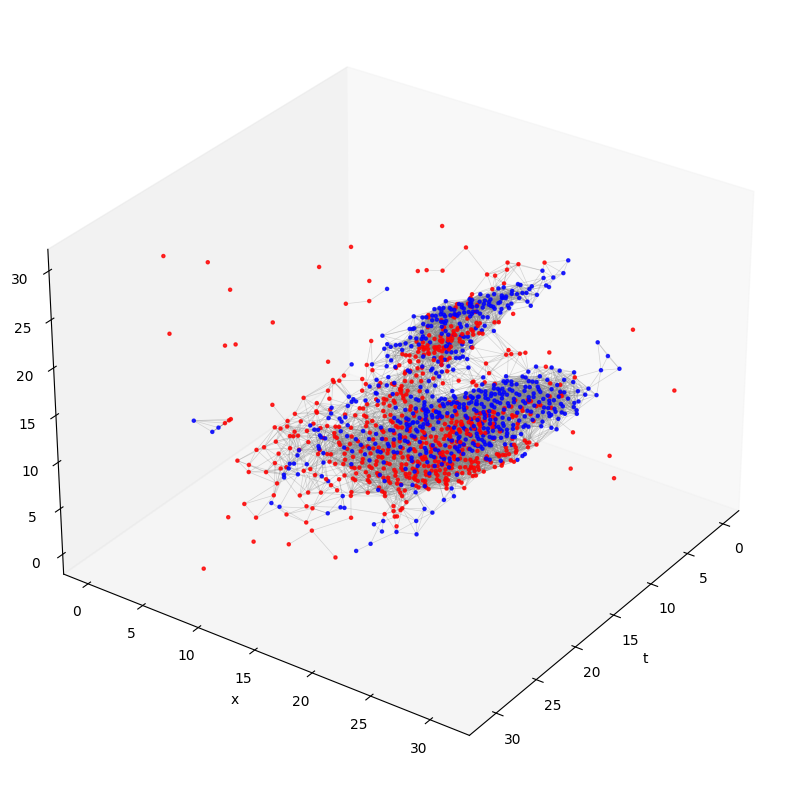

In [25]:
# Convert tensors to numpy for plotting
pos_np = pos.numpy()
edges_np = edges.numpy()

fig = plt.figure(figsize=(10, 8))

# ---- View 1: top-down ----
ax = fig.add_subplot(1, 1, 1, projection='3d')
sc1 = ax.scatter(pos_np[:,2], pos_np[:,0], 31 - pos_np[:,1], c=p, cmap='bwr', s=5, alpha=0.8)
ax.set_xlabel("t"); ax.set_ylabel("x"); ax.set_zlabel("y")
ax.view_init(elev=30, azim=35)
ax.grid(False)

# Draw edges
for (src, dst) in edges_np:
    if src < len(pos_np) and dst < len(pos_np):
        x_line = [pos_np[src, 0], pos_np[dst, 0]]
        y_line = [31-pos_np[src, 1], 31-pos_np[dst, 1]] # 31-y to flip Y-axis
        t_line = [pos_np[src, 2], pos_np[dst, 2]]
        ax.plot(t_line, x_line, y_line, color='gray', alpha=0.3, linewidth=0.5)

plt.tight_layout()
plt.show()


Lets wrap up all inside NMNIST dataset class.

1. Sample a file from the dataset list.
2. Determine the digit class by parsing the file’s directory name (e.g., `.../3/...` → digit 3), then convert it into a `torch.tensor([y], dtype=torch.long)`.
3. Use the provided `read_dataset()` function to load the event data (x, y, t, p).
4. Apply a temporal mask to include only events within the first 100 milliseconds.
5. Map event timestamps into the range **[0, 31]**: $t' = 31 * \frac{t - \min(t)}{\max(t) - \min(t)}$. To avoid division by zero, use `max(1e-12, t.max() - t.min())`.
6. Convert events into torch tensor of `x` - features as a polarities and `pos` as spatio-temporal positions of events.
8. Build the event graph using the optimized C++ function with `r=3.0` and `k=32`.


In [26]:
class NMNIST(torch.utils.data.Dataset):
    def __init__(self, data_dir):
        self.data_dir = data_dir
        self.event_files = glob.glob(os.path.join(data_dir, '*/*'))

    def __len__(self):
        return len(self.event_files)

    def __getitem__(self, idx):
        event_file = self.event_files[idx]
        y = int(event_file.split(os.sep)[-2])
        y = torch.tensor([y], dtype=torch.long)

        # Read your events
        timestamps, xaddr, yaddr, pol = read_dataset(event_file)

        # select only first 100 ms (100,000 microseconds)
        start_time = timestamps.min()
        mask = timestamps <= start_time + 100000
        timestamps = timestamps[mask]
        xaddr = xaddr[mask]
        yaddr = yaddr[mask]
        pol = pol[mask]

        # Normalize t to [0, 31] as in example
        t_min = timestamps.min()
        t_max = timestamps.max()
        t_range = max(1e-12, t_max - t_min)  # Avoid division by zero
        t = 31 * (timestamps - t_min) / t_range

        x = torch.tensor(pol, dtype=torch.float32).unsqueeze(-1)
        pos = torch.from_numpy(np.column_stack((xaddr, yaddr, t))).contiguous().to(torch.float32)
        edge_index = radius_cpu_ext.radius_graph_cpu(pos, r=3.0, k=32)

        return {'x': x.to(torch.float32),
                'pos': pos.to(torch.float32),
                'edge_index': edge_index.to(torch.long),
                'y': y}

Great — we now have our own **event-graph dataset**.

### How we represent the graph

If we inspect the shapes:

```python
print(edges.shape)  # torch.Size([13883, 2])
print(pos.shape)    # torch.Size([1209, 3])
print(x.shape)      # torch.Size([1209, 1])
```

This edge list is in **COO (Coordinate) format**. Instead of storing a large, mostly sparse (N \times N) adjacency matrix (see the visualization earlier), we store edges as an (E \times 2) tensor, where (E) is the number of edges.
Each row contains two indices: **[target_node, source_node]** (indices into `pos` and `x`). Thus, for an edge `[i, j]`, information flows **from node `j` → node `i`**.
With this, we store `[13883 × 2]` instead of `[1209 × 1209]`.


### How we batch multiple graphs

During training we want to process, e.g. **32 graphs** at once. Because graphs are unstructured, each can have a different number of nodes and edges. We **cannot** simply add a batch dimension to `pos`, `x`, and `edges`.

Instead, we:

* **Concatenate** all `pos_i` and `x_i` across graphs into longer `pos` and `x`.
* **Shift edge indices** for each graph by an offset equal to the current total number of nodes so far (so edges still point to the correct nodes after concatenation).
* Build a **`batch` vector** of length equal to the number of nodes, where each entry stores the **graph ID** for that node (used by pooling/readout ops).
* Stack labels `y_i` into a single tensor.

We wrap this logic (and stacking `y`) in a **`collate_fn`** for the dataloader:

In [ ]:
def collate_fn(data_list):
    x = torch.cat([d['x'] for d in data_list], dim=0)
    pos = torch.cat([d['pos'] for d in data_list], dim=0)

    edge_index_list, offset = [], 0
    for i, d in enumerate(data_list):
        edges = d['edge_index']
        
        # DEBUG: Print each sample's edge_index shape
        # print(f"Sample {i}: edge_index shape: {edges.shape}")
        
        # Ensure edges have consistent shape [2, num_edges]
        if edges.dim() == 1:
            # If it's 1D, reshape to [2, num_edges//2]
            edges = edges.view(2, -1)
        elif edges.size(0) != 2:
            # If first dimension is not 2, transpose it
            edges = edges.t().contiguous()
        
        # Apply offset to both source and target nodes
        edges = edges + offset
        edge_index_list.append(edges)
        offset += d['x'].shape[0]
    
    # Concatenate along the edges dimension (dim=1)
    if edge_index_list:
        # Verify all tensors have the same size in dimension 0
        first_dim = edge_index_list[0].size(0)
        for i, edges in enumerate(edge_index_list):
            if edges.size(0) != first_dim:
                print(f"WARNING: Sample {i} has inconsistent edge_index shape: {edges.shape}")
                # Force reshape to match
                if edges.dim() == 2 and edges.size(1) > 0:
                    edges = edges[:first_dim, :]  # Take first 'first_dim' rows
                else:
                    # Create empty tensor with correct shape
                    edges = torch.zeros((first_dim, 0), dtype=edges.dtype, device=edges.device)
                edge_index_list[i] = edges
        
        edge_index = torch.cat(edge_index_list, dim=1)
    else:
        edge_index = torch.zeros((2, 0), dtype=torch.long, device=x.device)
    
    # print(f"Final batch edge_index shape: {edge_index.shape}")

    y = torch.stack([d['y'] for d in data_list], dim=0).squeeze()
    batch = torch.cat([
        torch.full((d['x'].shape[0],), i, dtype=torch.long)
        for i, d in enumerate(data_list)
    ], dim=0)

    return {"x": x,
            "pos": pos,
            "edge_index": edge_index,
            "y": y,
            "batch": batch}

In [28]:
# Dataset
train_dataset = NMNIST("Train")
test_dataset = NMNIST("Test")

# Dataloaders
train_dataloader = DataLoader(train_dataset, 32, shuffle=True, num_workers=16, collate_fn=collate_fn)
test_dataloader = DataLoader(test_dataset, 32, shuffle=False, num_workers=16, collate_fn=collate_fn)

We now have an **event-graph dataset** and need **graph convolutions** to operate on this irregular structure.

### Why “graph convolutions”?

Generalizing convolution to graphs is commonly framed as **message passing** or **neighborhood aggregation**. For each node $(x_i)$, the operation proceeds in three stages:

1. **Message**: compute messages from neighbors,
2. **Aggregation**: combine incoming messages (e.g., **max**, **sum**, **mean**),
3. **Update**: update the node feature using the aggregated result.

There are many graph convolution layers with different design choices about **what** is passed (node features, positions, edge attributes), **how** it’s aggregated, and **how** nodes are updated. See PyG’s [convolutional layers](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#convolutional-layers) for popular options like **GCNConv**, **GAT**, **EdgeConv**, **SplineConv**. In this course we focus on **PointNetConv**, which in my [experiments](https://arxiv.org/pdf/2307.14124) strikes a strong balance of **accuracy**, **speed**, and—most importantly—**memory use**.

### PointNetConv: message passing form

$\mathbf{x}^{\prime}_i = \gamma_{\mathbf{\Theta}} \left( \max_{j \in
\mathcal{N}(i) \cup \{ i \}} h_{\mathbf{\Theta}} ( \mathbf{x}_j,
\mathbf{p}_j - \mathbf{p}_i) \right),$

where $(h_{\boldsymbol\Theta})$ and $(\gamma_{\boldsymbol\Theta})$ are MLPs. The term $(\mathbf{p}_j - \mathbf{p}_i)$ is the **relative position** (here: spatio-temporal offset) that injects geometric context.

**Intuition:** for each **target** node (i), iterate over neighbors $(j \in \mathcal{N}(i))$, build a message from the neighbor’s feature $(\mathbf{x}_j)$ and relative position $(\mathbf{p}_j - \mathbf{p}_i)$, transform it with a small network, **aggregate** across neighbors using element-wise **max**, then **update** the node with another small network.

We will implement this **in parallel** to fully utilize CUDA cores.


---

## Our PointNetConv design

* Initialize two linear layers:

  * `lin_local`: **message function** (input_dim to output_dim),
  * `lin_global`: **update function** (output_dim to output_dim).

### Forward pass structure

#### 1. Message function

* Use `edge_index` to gather:

  * `pos_i` = positions of **targets** (`edge_index[:, 0]`),
  * `pos_j` = positions of **sources** (`edge_index[:, 1]`),
  * `x_j`   = features of **sources** (`edge_index[:, 1]`).
* Build messages by concatenating (`torch.cat` with `dim=1`) neighbor features and relative positions:
  $$
  \text{msg} = \big[x_j | (p_j - p_i)\big]
  $$
  and pass through `lin_local`.

#### 2. Aggregation function

We aggregate per **target node** using PyTorch’s `scatter_reduce`, which applies a reduction over values routed by an index vector—ideal for sparse graph ops.

<img src="https://raw.githubusercontent.com/vision-agh/DNN-Course-media/refs/heads/main/lab9_gcn/figures/scatter.png" width="400px">

Steps:

1. Compute **unique target indices** and the inverse mapping with `torch.unique(..., return_inverse=True)` on the target column of `edge_index`.
2. **Expand** the inverse indices to match `msg`’s feature dimension (`.unsqueeze(1).expand(-1, self.output_dim)`).
3. Allocate `pooled_features = torch.zeros((unique_positions.size(0), output_dim), dtype=msg.dtype, device=x.device)`.
4. Apply `scatter_reduce` on `pooled_features` with:

   * `dim=0`,
   * `index=expanded_indices`,
   * `src=msg`,
   * `reduce="amax"`,
   * `include_self=False`.

This yields element-wise **max** over all incoming messages per target node.

#### 3. Update function

* Apply `lin_global` to `pooled_features` to produce the final updated node features.

In [29]:
class PointNetConv(nn.Module):
    def __init__(self, input_dim: int, output_dim: int, bias: bool = False):
        super().__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        # +3 for relative positions (x_j - x_i, y_j - y_i, t_j - t_i)
        self.lin_local = Linear(input_dim + 3, output_dim, bias=bias)
        self.lin_global = Linear(output_dim, output_dim, bias=bias)

    def forward(self, x: torch.Tensor, pos: torch.Tensor, edge_index: torch.Tensor):
        # Ensure edge_index has correct shape [2, num_edges]
        if edge_index.dim() == 1:
            edge_index = edge_index.view(2, -1)
        elif edge_index.size(0) != 2:
            edge_index = edge_index.t().contiguous()
        
        # Message function
        target_nodes = edge_index[0]  # shape: [num_edges]
        source_nodes = edge_index[1]  # shape: [num_edges]
        
        pos_i = pos[target_nodes]  # [num_edges, 3]
        pos_j = pos[source_nodes]  # [num_edges, 3]
        x_j = x[source_nodes]      # [num_edges, input_dim]

        # Concatenate source features with relative positions
        msg = torch.cat([x_j, pos_j - pos_i], dim=1)  # [num_edges, input_dim + 3]
        msg = self.lin_local(msg)  # [num_edges, output_dim]

        # Aggregation: max pooling per target node
        num_nodes = x.size(0)
        aggregated = torch.zeros(num_nodes, self.output_dim, 
                               dtype=msg.dtype, device=x.device)
        
        # Use scatter with max reduction
        aggregated = aggregated.scatter_reduce(
            dim=0,
            index=target_nodes.unsqueeze(1).expand(-1, self.output_dim),
            src=msg,
            reduce="amax",
            include_self=False
        )

        # Update function
        out = self.lin_global(aggregated)
        return out

    def __repr__(self):
        return f"{self.__class__.__name__}(linear_local={self.lin_local})(linear_global={self.lin_global})"

We can now test whether our convolution layer works correctly.
We initialize the `PointNetConv` with **input channels = 1 + 3**, where:

* **1** corresponds to the event **feature** (polarity),
* **3** corresponds to the **position** components ((x, y, t)).

After passing the data through the layer, only the **feature tensor `x`** should change its dimensionality — from **1 → 32** — while the position and edge information remain the same.

In [30]:
# Fix the initialization - only pass node feature dimension
conv = PointNetConv(1, 32)  # input: feature(1) only, positions handled separately

batch = next(iter(train_dataloader))

x = batch['x']                      # node features (polarity)
pos = batch['pos']                  # spatio-temporal positions [x, y, t]
edge_index = batch['edge_index']    # edge connections [E, 2] (target, source)

print("Before:", x.shape, pos.shape, edge_index.shape)
x = conv(x, pos, edge_index)
print("After:", x.shape, pos.shape, edge_index.shape)

Before: torch.Size([46474, 1]) torch.Size([46474, 3]) torch.Size([2, 847244])


IndexError: index 277653 is out of bounds for dimension 0 with size 46474

Our objective is to **predict the class of each graph**. For a batch of ( B ) graphs from the N-MNIST dataset, the model should output a tensor of shape **((B, 10))**, where 10 corresponds to the digit classes $(0\ldots9)$.

After a series of graph convolutions, we need to **aggregate node features** into a compact, fixed-size embedding suitable for an MLP classifier. The simplest aggregations are **mean** or **max** over all nodes. However, for event data it’s often better to apply a **max-like pooling locally**—not across the whole graph at once, but over **spatial subregions** while **preserving the temporal axis**.
Example: split a graph with maximum extent $(32 \times 32 \times 32)$ into **$(4 \times 4 = 16)$** spatial tiles of size $(8 \times 8 \times 32)$ (time stays at 32). We then pool within each spatial tile (across nodes that fall inside it) and **concatenate** the pooled features from all tiles. This retains information from different parts of the field of view and yields a richer global embedding. We’ll implement this as **`GraphPoolOut2D`**.

### GraphPoolOut2D implementation

**Parameters**

* `pool_size`: spatial pooling size applied to **X** and **Y** positions (e.g. 8).
* `max_dimension`: the **original spatial resolution** per axis (e.g. 32).
  From these, `grid_size = max_dimension // pool_size`.
  With `max_dimension=32` and `pool_size=8`, we get `grid_size=4` and thus **$(4 \times 4 = 16)$** subgraphs.
  If the channel dimension after GCN layers is (C), the final pooled vector per graph has size $(4 \times 4 \times C = 16C)$.

### Forward pass

1. **Quantize spatial positions to grid cells**
   Compute integer tile coordinates from positions:
   `qpos = (pos[:, :2] // pool_size).long()`
   (use only `x` and `y`; **do not** quantize time).

2. **Form keys that include batch IDs**
   Stack batch indices with the quantized coordinates (`[batch, qpos[:, 0], qpos[:, 1]` with `dim=1`) to keep information about batch index for each node.

3. **Group nodes by unique (batch, cell_x, cell_y)**
   Use `torch.unique(key, dim=0, return_inverse=True)` to get:

   * `unique_keys`: one row per **unique cell per batch**,
   * `inv`: an index mapping each node to its cell.
     Then:
   * `new_batch = unique_keys[:, 0]`
   * `uniq_qpos = unique_keys[:, 1:]`
   * `expand_inv = inv.unsqueeze(1).expand(-1, x.size(1))` to match feature width.

4. **Aggregate features within each cell (amax pooling)**
   Create `pooled_x = zeros(unique_keys.size(0), x.size(1))` (same dtype/device as `x`) and apply
   `scatter_reduce` with dim=0, index=expand_inv, src=x, reduce="amax", include_self=False.

5. **Compute linear cell indices**
   Convert 2D cell coords to a flat index:
   `grid_idx = uniq_qpos[:, 0] * grid_size + uniq_qpos[:, 1]`.

6. **Place pooled features into a fixed grid tensor**
   Initialize `out = zeros(batch.max() + 1, grid_size ** 2, x.size(1))`.
   Fill `out[new_batch, grid_idx]` with `pooled_x`.

7. **Flatten per-graph embeddings**
   Return `out.flatten(1)`.



In [ ]:
class GraphPoolOut2D(nn.Module):
    def __init__(self, pool_size: int = 8, max_dimension: int = 32):
        super().__init__()
        self.pool_size = pool_size
        self.max_dimension = max_dimension
        self.grid_size = max_dimension // pool_size

    def forward(self, x: torch.Tensor, pos: torch.Tensor, batch: torch.Tensor):
        # Quantize positions to grid cells
        qpos = (pos[:, :2] // self.pool_size).long()  # divide pos (for x and y) with pool_size
        key = torch.stack([batch, qpos[:, 0], qpos[:, 1]], dim=1)  # stack batch with qpos[:,0] and qpos[:,1]

        # Find unique grid cells per batch
        unique_keys, inv = torch.unique(key, dim=0, return_inverse=True)  # use torch.unique
        new_batch = unique_keys[:, 0]
        uniq_qpos = unique_keys[:, 1:]
        expand_inv = inv.unsqueeze(1).expand(-1, x.size(1))

        # Max pooling within each cell
        pooled_x = torch.zeros(unique_keys.size(0), x.size(1), device=x.device, dtype=x.dtype)
        pooled_x = pooled_x.scatter_reduce(
            dim=0, index=expand_inv, src=x, reduce="amax", include_self=False
        )  # use scatter_reduce

        # Compute flat grid index and assign to output tensor
        grid_idx = uniq_qpos[:, 0] * self.grid_size + uniq_qpos[:, 1]  # compute flat index
        out = torch.zeros((batch.max() + 1, self.grid_size ** 2, x.size(1)),
                          device=x.device, dtype=x.dtype)
        out[new_batch, grid_idx] = pooled_x

        return out.flatten(1)

    def __repr__(self):
        return f"{self.__class__.__name__}(pool_size={self.pool_size}, max_dimension={self.max_dimension})"

Let’s verify the output of our pooling layer.
If we process a **batch of 32 graphs** (so (B = 32)) and each node initially has **1 feature channel**, then after applying `GraphPoolOut2D` we expect the output to have the shape [32, 16].

In [ ]:
pool = GraphPoolOut2D(8, 32)

batch = next(iter(train_dataloader))

x = batch['x']                      # node features (polarity)
pos = batch['pos']                  # spatio-temporal positions [x, y, t]
edge_index = batch['edge_index']    # edge connections [E, 2] (target, source)
batch_idx = batch['batch']

print("Before:", x.shape, pos.shape, batch_idx.shape)
x = pool(x, pos, batch_idx)
print("After:", x.shape)


Before: torch.Size([48622, 1]) torch.Size([48622, 3]) torch.Size([48622])
After: torch.Size([32, 16])


Now we can **stack our layers to build the complete model**.

The architecture will consist of:

1. **Three `PointNetConv` layers**, each producing **32 output features**.
   After each convolution, we apply:

   * a **ReLU** activation, and
   * a **BatchNorm1d** normalization.

2. A **`GraphPoolOut2D`** layer to aggregate spatial information from each graph into a compact feature vector after last conv layer.

3. A **fully connected (Linear)** classification layer that maps the pooled embedding to digit classes.
   With `max_dimension = 32` and `pool_size = 8`, we have (4 \times 4 = 16) pooled regions, each with 32 features, giving an input size of (4 * 4 * 32 = 512).

In [ ]:
class GCN(Module):
    def __init__(self):
        super().__init__()
        self.conv1 = PointNetConv(1+3, 32, bias=True)
        self.norm1 = BatchNorm1d(32)
        self.conv2 = PointNetConv(32+3, 32, bias=True)
        self.norm2 = BatchNorm1d(32)
        self.conv3 = PointNetConv(32+3, 32, bias=True)
        self.norm3 = BatchNorm1d(32)
        self.pool_out = GraphPoolOut2D(pool_size=8, max_dimension=32)
        self.linear = Linear(4*4*32, 10)

    def forward(self, x, pos, edges, batch):
        x = self.conv1(x, pos, edges)
        x = F.relu(x)
        x = self.norm1(x)

        x = self.conv2(x, pos, edges)
        x = F.relu(x)
        x = self.norm2(x)

        x = self.conv3(x, pos, edges)
        x = F.relu(x)
        x = self.norm3(x)

        x = self.pool_out(x, pos, batch)
        x = self.linear(x)

        return x

We can wrap it to Lightning module. We can use standard backpropagation with Adam optimizers.

In [ ]:
from torchmetrics.classification import MulticlassAccuracy

class GCN_MNIST(L.LightningModule):
    def __init__(self):
        super().__init__()

        self.conv1 = PointNetConv(1, 32)  # Input: 1 feature (polarity)
        self.norm1 = nn.BatchNorm1d(32)
        self.conv2 = PointNetConv(32, 64)  # Input: 32 features from previous layer
        self.norm2 = nn.BatchNorm1d(64)
        self.conv3 = PointNetConv(64, 128)  # Input: 64 features from previous layer
        self.norm3 = nn.BatchNorm1d(128)

        self.pool = GraphPoolOut2D(pool_size=8, max_dimension=32)

        # After pooling: grid_size=4, so 4x4=16 spatial cells, each with 128 features
        self.lin1 = nn.Linear(16 * 128, 256)
        self.lin2 = nn.Linear(256, 10)

        self.criterion = nn.CrossEntropyLoss()
        self.train_acc = MulticlassAccuracy(num_classes=10)
        self.val_acc = MulticlassAccuracy(num_classes=10)
        self.test_acc = MulticlassAccuracy(num_classes=10)

    def forward(self, x, pos, edges, batch):
        x = self.conv1(x, pos, edges)
        x = F.relu(x)
        x = self.norm1(x)

        x = self.conv2(x, pos, edges)
        x = F.relu(x)
        x = self.norm2(x)

        x = self.conv3(x, pos, edges)
        x = F.relu(x)
        x = self.norm3(x)

        x = self.pool(x, pos, batch)
        x = F.relu(self.lin1(x))
        x = self.lin2(x)
        return x

    def step(self, batch):
        x = batch["x"]
        pos = batch["pos"]
        edge_index = batch["edge_index"]
        y = batch["y"]
        batch_vec = batch["batch"]

        # FIX: Use self(...) instead of self.model(...)
        out = self(x, pos, edge_index, batch_vec)
        loss = self.criterion(out, y)
        preds = out.argmax(dim=1)
        batch_size = y.size(0)
        return loss, preds, y, batch_size

    def training_step(self, batch, batch_idx):
        loss, preds, y, batch_size = self.step(batch)
        acc = self.train_acc(preds, y)
        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True, batch_size=batch_size)
        self.log("train_acc", acc, on_step=True, on_epoch=True, prog_bar=True, batch_size=batch_size)
        return loss

    def validation_step(self, batch, batch_idx):
        loss, preds, y, batch_size = self.step(batch)
        acc = self.val_acc(preds, y)
        self.log("val_loss", loss, on_epoch=True, prog_bar=True, batch_size=batch_size)
        self.log("val_acc", acc, on_epoch=True, prog_bar=True, batch_size=batch_size)

    def test_step(self, batch, batch_idx):
        loss, preds, y, batch_size = self.step(batch)
        acc = self.test_acc(preds, y)
        self.log("test_loss", loss, on_epoch=True)
        self.log("test_acc", acc, on_epoch=True)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.001)

And start training as normal model.

In [ ]:
# W&B logger
wandb_logger = WandbLogger(project="lab9-gcn",
                           entity="deep-neural-network-course",
                           group="gcn",
                           name="Jan Rosa",
                           log_model=True)

# Model + Trainer setup
model = GCN_MNIST()

checkpoint_callback = ModelCheckpoint(
        dirpath="./checkpoints",
        filename="gcn-{epoch:02d}-{train_loss:.4f}",
        save_top_k=1,
        monitor="train_loss",
        mode="min"
    )

trainer = L.Trainer(
    max_epochs=5,
    logger=wandb_logger,
    callbacks=[checkpoint_callback],
    log_every_n_steps=50
)

# Add this debugging code before training
print("=== DEBUGGING EDGE_INDEX SHAPES ===")

# Test a single sample from the dataset
train_dataset = NMNIST("Train")
sample = train_dataset[0]
print(f"Single sample edge_index shape: {sample['edge_index'].shape}")
print(f"Single sample edge_index: {sample['edge_index']}")

# Test the collate function
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=24, collate_fn=collate_fn)
batch = next(iter(train_dataloader))
print(f"Batch edge_index shape: {batch['edge_index'].shape}")
print(f"Batch x shape: {batch['x'].shape}")
print(f"Batch pos shape: {batch['pos'].shape}")

# Check if edge_index has the correct format
edge_index = batch['edge_index']
print(f"edge_index min: {edge_index.min()}, max: {edge_index.max()}")
print(f"Number of nodes: {batch['x'].shape[0]}")
print(f"edge_index unique values in first row: {torch.unique(edge_index[0])}")
print(f"edge_index unique values in second row: {torch.unique(edge_index[1])}")

trainer.fit(model, train_dataloader, test_dataloader)
wandb.finish()

NameError: name 'WandbLogger' is not defined